## Parameter Estimation Workflow
A single optimization problem run many times can reveal more information that running just the once. Pycotools is geared towards running and analysing multiple parameter estimations

In [1]:
%matplotlib inline
import site, os, glob, pandas
site.addsitedir(r'C:/Users/Ciaran/Documents/pycotools')
site.addsitedir(r'/home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc

/home/b3053674/Documents/pycotools/pycotools/viz.py:117: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError


### Build Example Model
Here we use the same model as in the QuickStart tutorial.

In [2]:
working_directory = r'C:\Users\Ciaran\Documents\PycotoolsQuickStart'
working_directory = r'/home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir'
copasi_file = os.path.join(working_directory, 'MichaelisMenten.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)

    
kf = 0.01
kb = 0.1
kcat = 0.05
with model.Build(copasi_file) as m:
    m.name = 'Michaelis-Menten'
    m.add('compartment', name='Cell')
    
    m.add('metabolite', name='P', concentration=0)
    m.add('metabolite', name='S', concentration=30)
    m.add('metabolite', name='E', concentration=10)
    m.add('metabolite', name='ES', concentration=0)
    
    m.add('reaction', name='S bind E', expression='S + E -> ES', rate_law='kf*S*E',
          parameter_values={'kf': kf})
    
    m.add('reaction', name='S unbind E', expression='ES -> S + E', rate_law='kb*ES',
         parameter_values={'kb': kb})

    m.add('reaction', name='ES produce P', expression='ES -> P + E', rate_law='kcat*ES', 
          parameter_values={'kcat': kcat})
    
michaelis_menten = model.Model(copasi_file)
michaelis_menten

Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)

#### Simulate Time Course

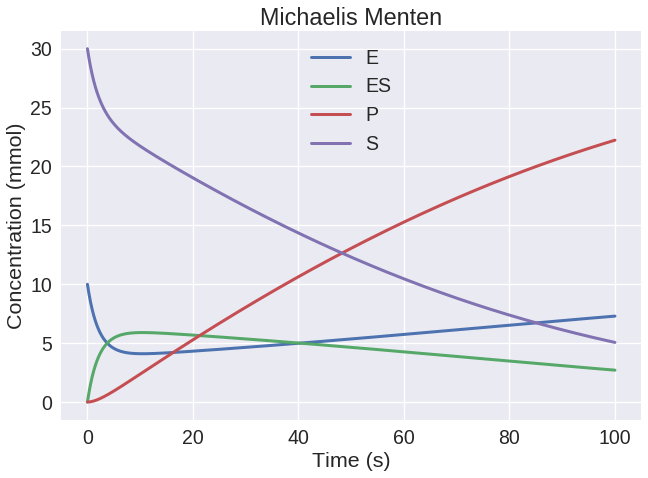

In [3]:
tc = tasks.TimeCourse(michaelis_menten, end=100, intervals=100, step_size=0.1)
viz.PlotTimeCourse(tc, separate=False, title='Michaelis Menten')

#### Generate Synthetic Data

In [4]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    michaelis_menten, start=0, end=100, intervals=10, step_size=10, report_name=report
)

pandas.read_csv(TC.report_name,sep='\t').head()

,Time,[E],[ES],[P],[S]
0,0,10.00000,0.00000,0.00000,30.0000
1,10,4.10191,5.89809,2.37588,21.7260
2,20,4.31725,5.68275,5.28367,19.0336
3,30,4.64091,5.35909,8.04533,16.5956
4,40,4.98869,5.01131,10.63880,14.3499


#### Format synthetic data
Copasi by default outputs outputs specie headers which do not exactly correspond to model components. Pycotools `misc.correct_copasi_output

In [5]:
misc.correct_copasi_timecourse_headers(TC.report_name)

,Time,E,ES,P,S
0,0,10.00000,0.00000,0.00000,30.00000
1,10,4.10191,5.89809,2.37588,21.72600
2,20,4.31725,5.68275,5.28367,19.03360
3,30,4.64091,5.35909,8.04533,16.59560
4,40,4.98869,5.01131,10.63880,14.34990
5,50,5.35620,4.64380,13.05330,12.30290
6,60,5.73910,4.26090,15.28000,10.45910
7,70,6.13163,3.86837,17.31260,8.81900
8,80,6.52677,3.47323,19.14800,7.37878
9,90,6.91678,3.08322,20.78670,6.13005


## Run parameter estimations
Here we opt to estimate everything.

In [26]:
fit1=tasks.MultiParameterEstimation(
    michaelis_menten, TC.report_name, copy_number=3, pe_number=20, 
    lower_bound=1e-3, upper_bound=5e3, 
    results_directory='fit1',
    method='genetic_algorithm_sr', population_size=150, number_of_generations=400,
    overwrite_config_file=True
)
    
fit1.write_config_file()
fit1.setup()
#fit1.run()

{0: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 1: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 2: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)}

## Exploratory data analysis on parameter estimation data 

### Evaluate the performance of the optimization algorithm

#### Likelihood-Ranks Plot


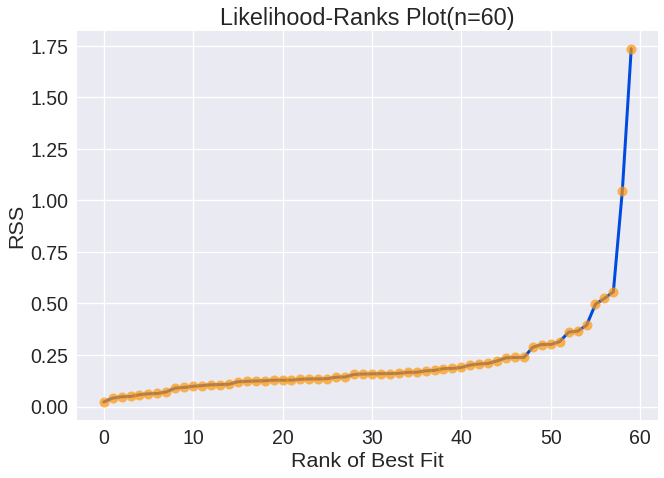

In [7]:
viz.LikelihoodRanks(fit1)

Most parameter sets (below rank of 50) have similar RSS values. However the smooth curve indicates the iterations are likely *not* finding the minima. 

#### PCA

pycotools.viz:INFO:2104:    plotting PCA iterations


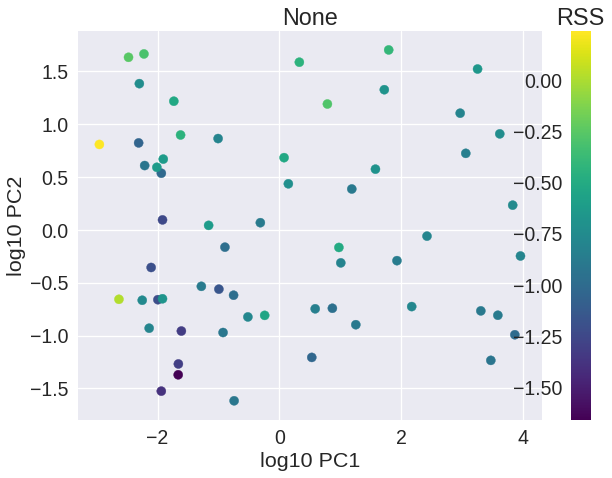

In [8]:
viz.Pca(fit1, by='iterations', log10=True)

PCA Shows a similar story in a different way. Despite parameter sets (each 2D coordinate here) being localed roughly in the same location (remember to look at the axes again) there is still some variation. 

### Distributions of parameters

#### Boxplots

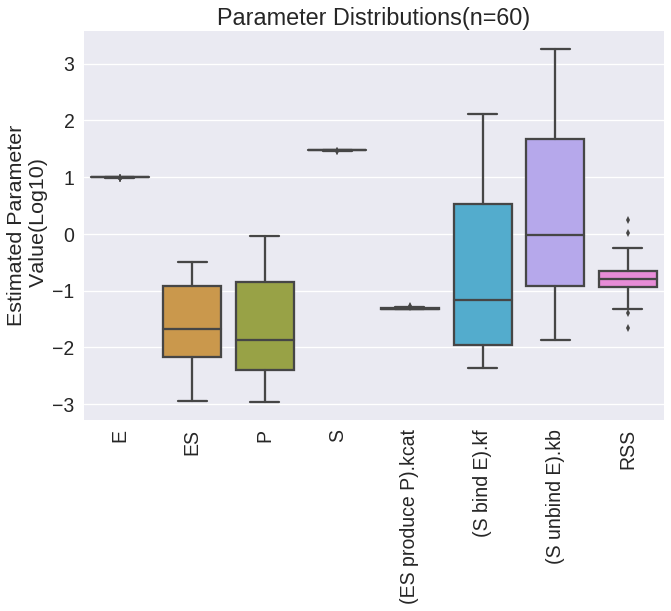

In [9]:
viz.Boxplots(fit1, num_per_plot=8, log10=True)

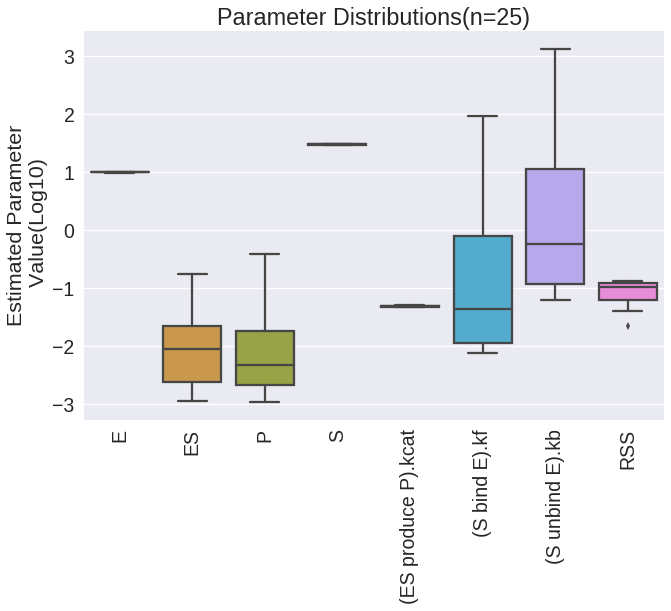

In [10]:
viz.Boxplots(fit1, num_per_plot=8, log10=True, truncate_mode='ranks', theta=range(25))

#### Histograms

pycotools.viz:INFO:2221:    plotting histograms


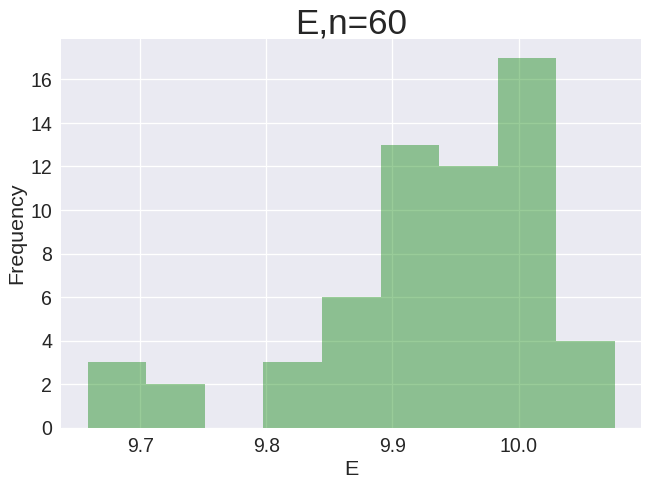

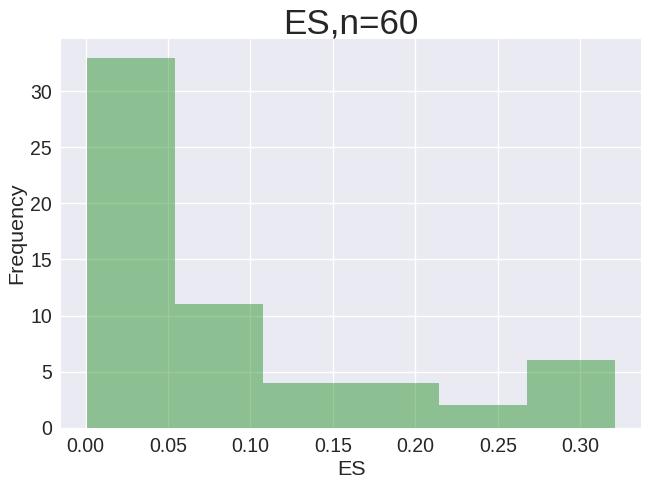

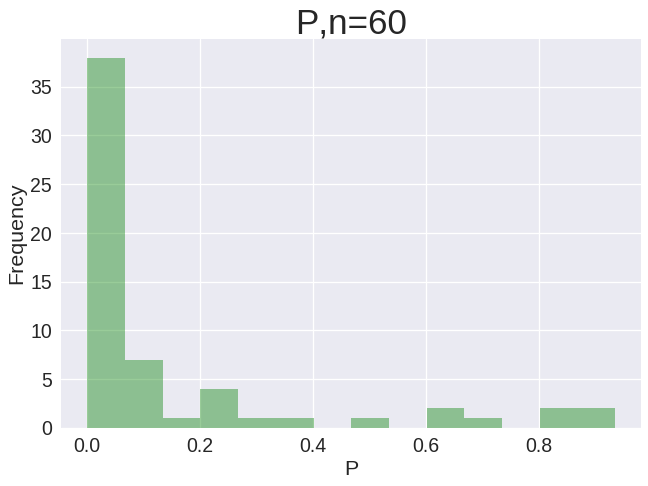

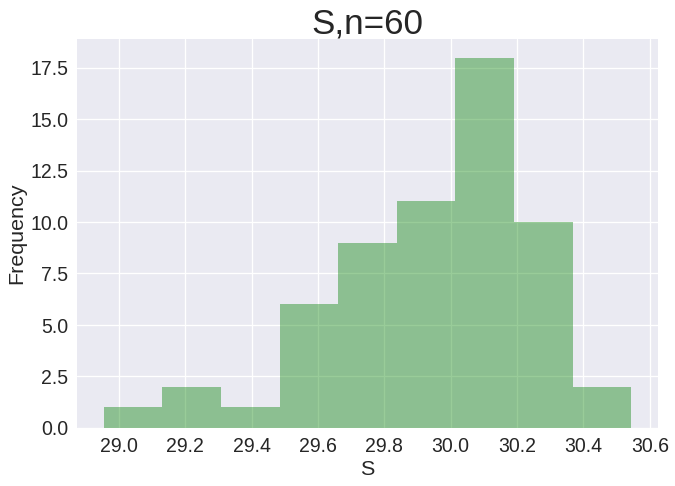

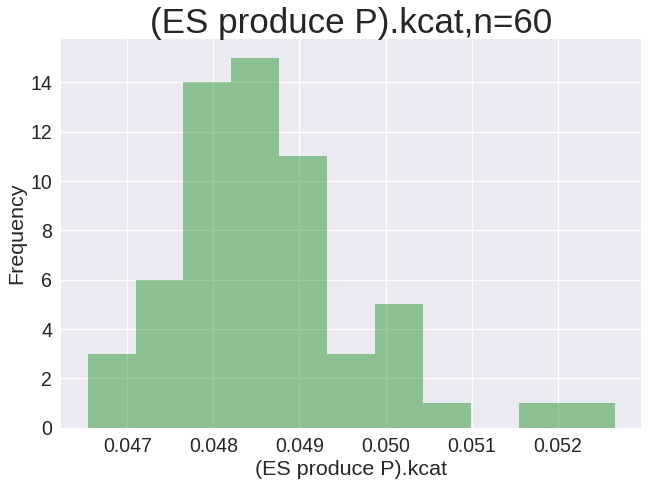

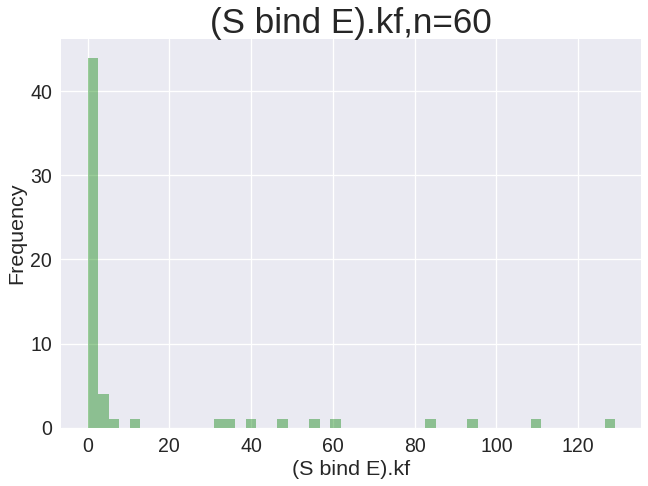

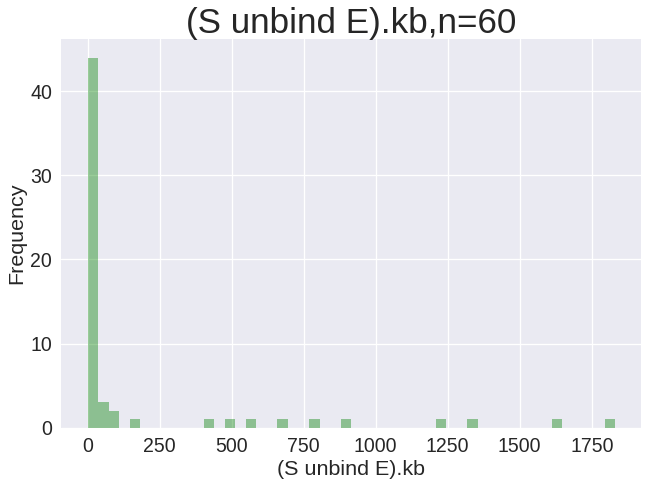

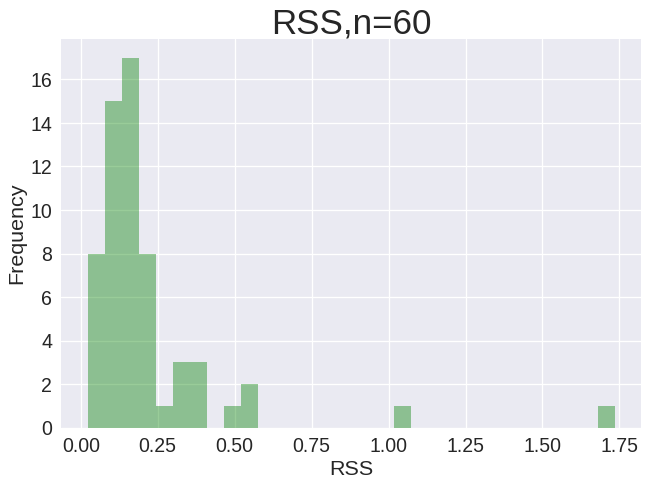

In [11]:
viz.Histograms(fit1)

### Correlations

#### Pearsons Correlations

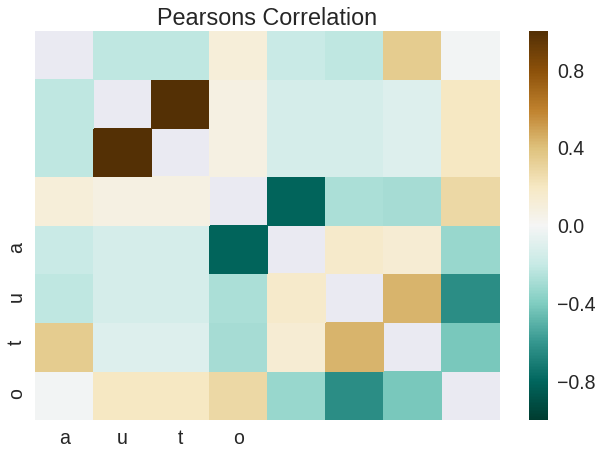

In [12]:
PC = viz.PearsonsCorrelation(fit1, show=True)
PC.heatmap()

In [13]:
PC.pearsons

,(ES produce P).kcat,(S bind E).kf,(S unbind E).kb,E,ES,P,RSS,S
(ES produce P).kcat,NaN,-0.223904,-0.221828,0.110895,-0.191911,-0.224552,0.343990,-0.015148
(S bind E).kf,-0.223904,NaN,0.999823,0.076832,-0.139070,-0.137481,-0.106764,0.199101
(S unbind E).kb,-0.221828,0.999823,NaN,0.076020,-0.138819,-0.137581,-0.106450,0.201001
E,0.110895,0.076832,0.076020,NaN,-0.809648,-0.276309,-0.293881,0.287408
ES,-0.191911,-0.139070,-0.138819,-0.809648,NaN,0.169443,0.139950,-0.328501
P,-0.224552,-0.137481,-0.137581,-0.276309,0.169443,NaN,0.439725,-0.635256
RSS,0.343990,-0.106764,-0.106450,-0.293881,0.139950,0.439725,NaN,-0.419480
S,-0.015148,0.199101,0.201001,0.287408,-0.328501,-0.635256,-0.419480,NaN


In [14]:
PC.p_val

,(ES produce P).kcat,(S bind E).kf,(S unbind E).kb,E,ES,P,RSS,S
(ES produce P).kcat,NaN,0.0854727722844,0.0884898029678,0.398934344886,0.141844617792,0.0845476297308,0.0071206765125,0.908543389892
(S bind E).kf,0.0854727722844,NaN,8.76590677631e-102,0.559568751533,0.289268159486,0.294865326438,0.416837817301,0.127233175124
(S unbind E).kb,0.0884898029678,8.76590677631e-102,NaN,0.563736520073,0.29014545669,0.294511628299,0.418216303513,0.123570736919
E,0.398934344886,0.559568751533,0.563736520073,NaN,4.82767957895e-15,0.0325939667506,0.0226620634286,0.0259718076239
ES,0.141844617792,0.289268159486,0.29014545669,4.82767957895e-15,NaN,0.195572668355,0.286196882878,0.0103897855445
P,0.0845476297308,0.294865326438,0.294511628299,0.0325939667506,0.195572668355,NaN,0.000439161425511,4.97653388046e-08
RSS,0.0071206765125,0.416837817301,0.418216303513,0.0226620634286,0.286196882878,0.000439161425511,NaN,0.000849179966385
S,0.908543389892,0.127233175124,0.123570736919,0.0259718076239,0.0103897855445,4.97653388046e-08,0.000849179966385,NaN


It appears that some of these parameters are statistically linearly correlated:

  * (S bind E).kf and (S unbind E).kb
  * E and ES
 

### Scatters
Now we have an idea of which pairs of parameters are linearly correlated we can target them with scatter plots. 

pycotools.viz:INFO:2434:    Plotting "S" Vs "E"


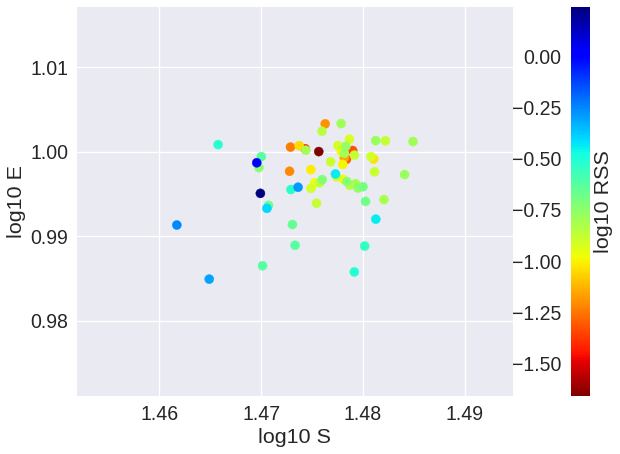

In [15]:
viz.Scatters(fit1, x=['S'], y=['E'], log10=True)

Remember to look at the scale of the axes. 

pycotools.viz:INFO:2434:    Plotting "(S unbind E).kb" Vs "(S bind E).kf"


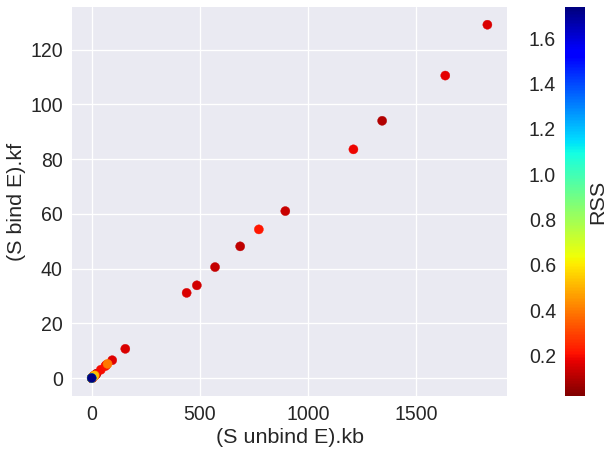

In [16]:
viz.Scatters(fit1, x=['(S unbind E).kb'], y=['(S bind E).kf'])

### Time course Ensemble

pycotools.viz:DEBUG:1304:    {'/home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/parameter_estimation_synthetic_data.txt': 0       0
1      10
2      20
3      30
4      40
5      50
6      60
7      70
8      80
9      90
10    100
Name: Time, dtype: int64}
pycotools.viz:INFO:1382:    Plotting "E"
pycotools.viz:INFO:1382:    Plotting "ES"
pycotools.viz:INFO:1382:    Plotting "P"
pycotools.viz:INFO:1382:    Plotting "S"


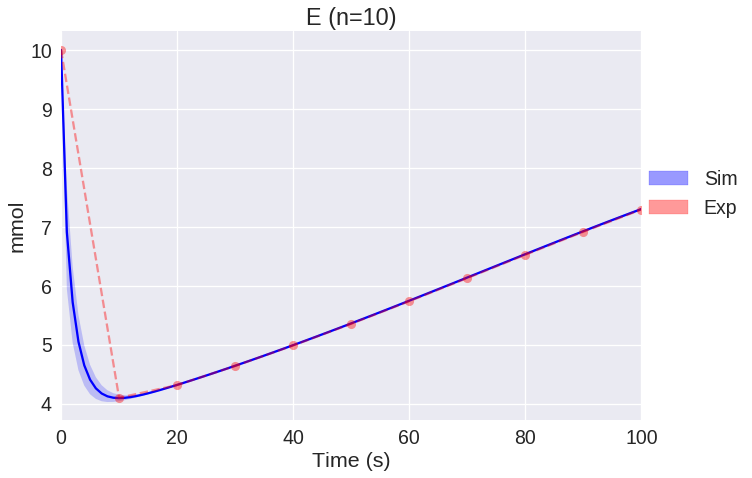

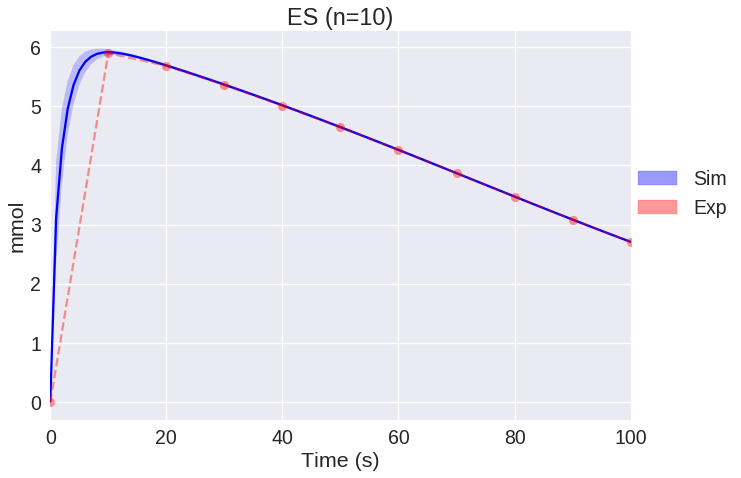

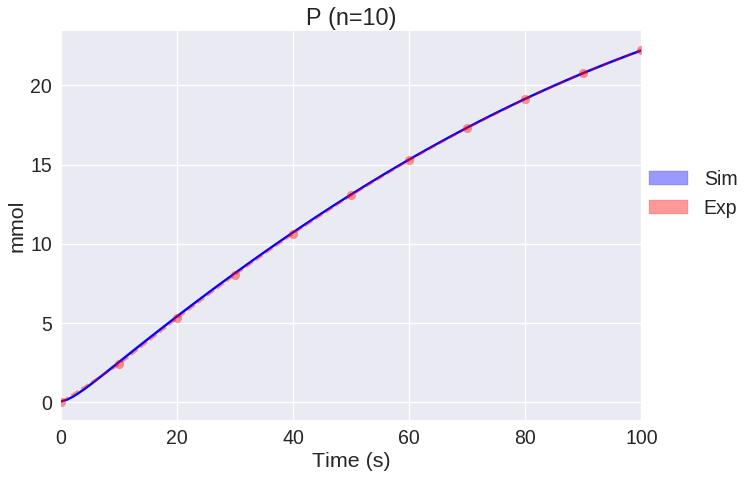

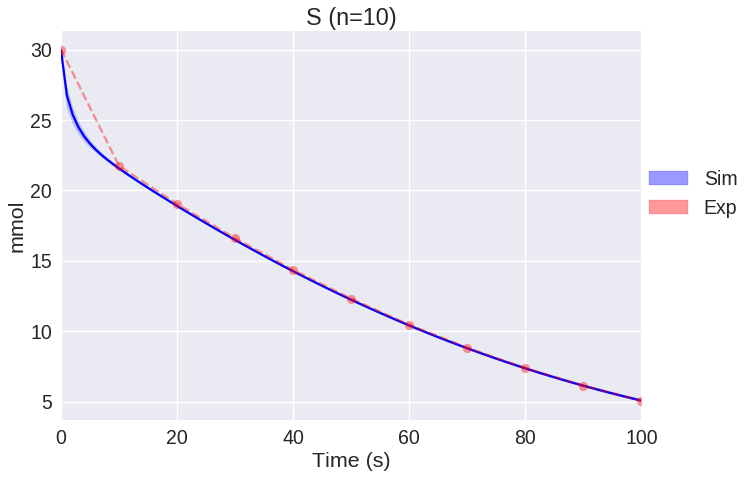

In [17]:
viz.PlotTimeCourseEnsemble(fit1, truncate_mode='ranks', theta=range(10))

Despite having correlated and imprecise parameter estimates it seems the fits are reasonable

### Profile Likelihoods

#### Run Local Chaser Estimation
First we ensure the best parameter set is at an actual minimum using Hooke and Jeeves - a deterministic parameter estimation algorithm which should produce the same result on each iteration. Despite this, here we use the MultiParameterEstimation class becuase it puts the results in a folder which can subsequently be used as argument to ProfileLikelihood. 

In [18]:
michaelis_menten.insert_parameters(parameter_path=fit1.results_directory, index=0)
fit1_2 = tasks.MultiParameterEstimation(michaelis_menten, TC.report_name, method='hooke_jeeves', 
                                      tolerance=1e-10, iteration_limit=300, 
                                      randomize_start_values=False, overwrite_config_file=True, 
                                      lower_bound=1e-3, upper_bound=5e3, 
                                      copy_number=2, pe_number=1, results_directory='chaser_estimations')

fit1_2.write_config_file()
fit1_2.setup()
fit1_2.run()
# michaelis_menten.open()

pycotools.tasks:DEBUG:581:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:581:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)


#### Run Profile Likelihoods

In [19]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=fit1_2.results_directory, 
                        log10=True, index=[0], intervals=30, run=True, results_directory='fit1_profile_likelihoods',
                        max_active=2)

pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S bind E).kf.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(ES produce P).kcat.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/P.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/S.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S unbind E).kb.cps
pycotools.tasks:INFO:4591:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES.cps


#### Plot  Profile Likelihoods
We can plot regular profile likelihoods. By default all profiles are plotted against RSS on the y axis. 

/home/b3053674/Documents/pycotools/pycotools/viz.py:3353: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_data = self.data.loc[x, i][y]


pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(ES produce P).kcat/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S bind E).kf/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S unbind E).kb/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/P/RSS.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWor

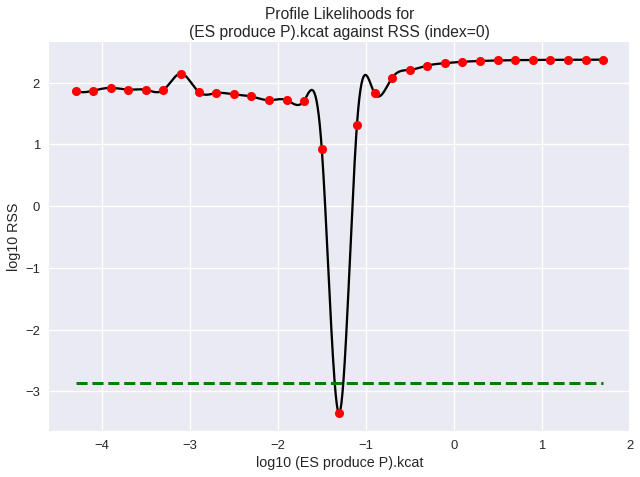

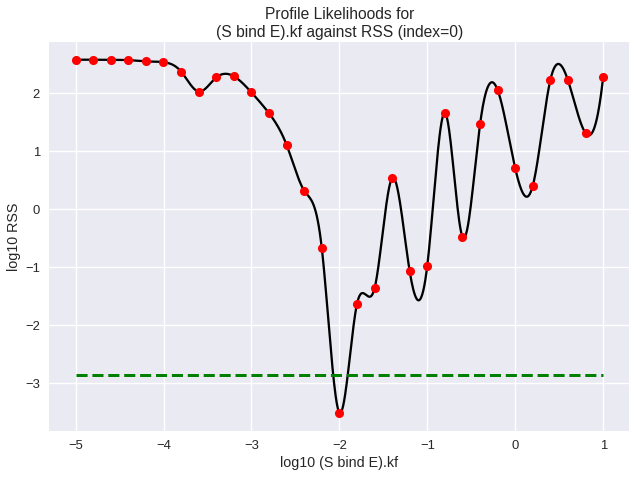

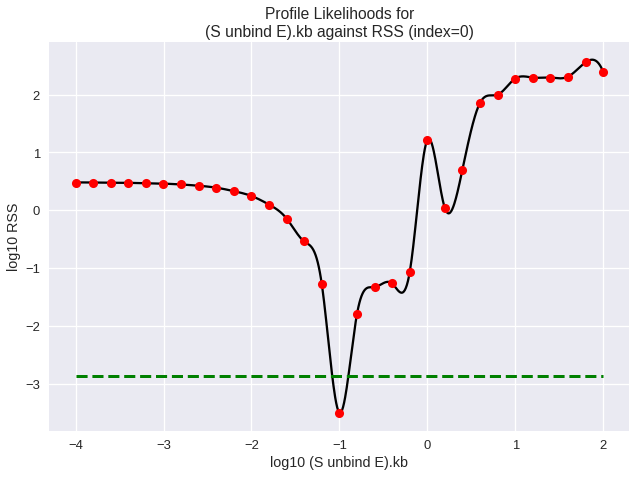

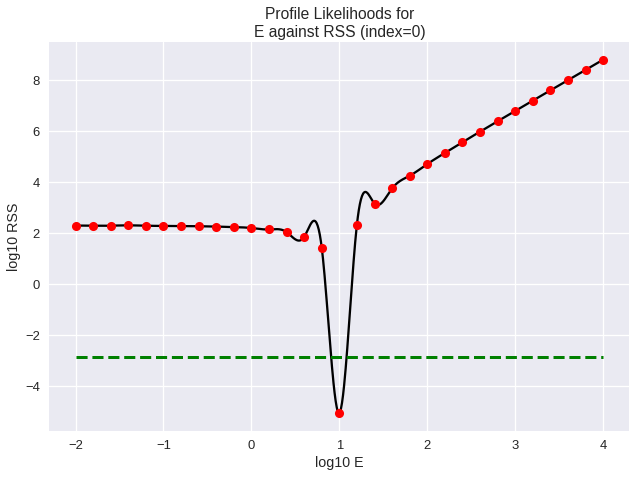

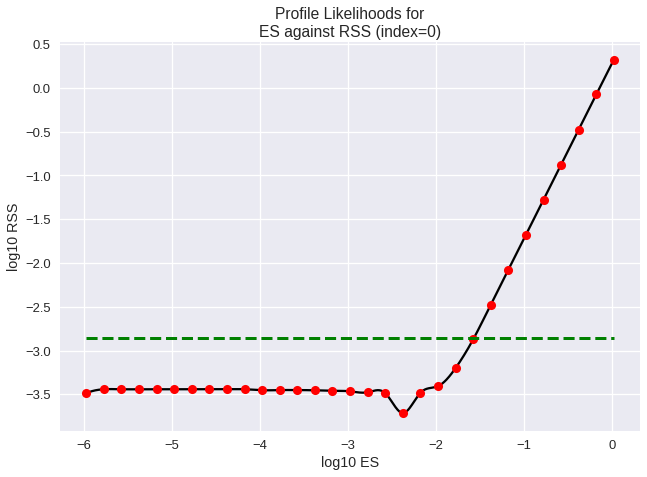

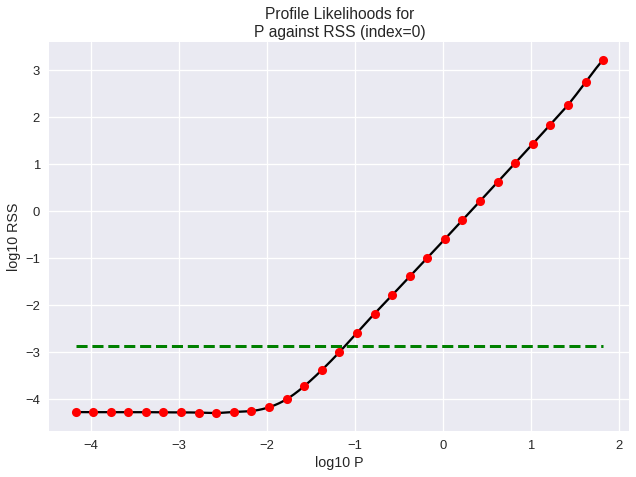

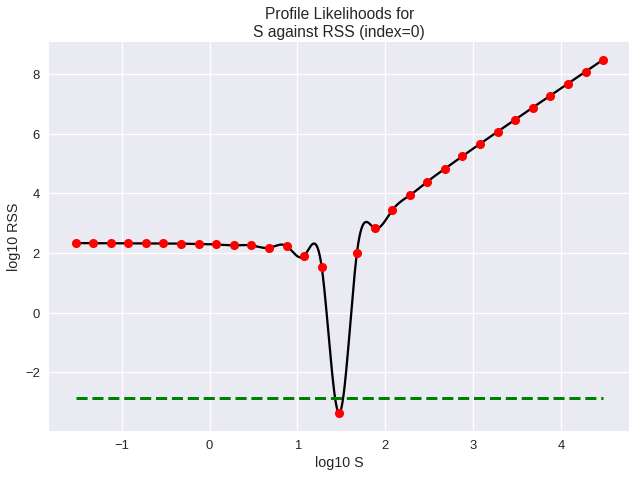

In [20]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', savefig=True)

From these plots, it appears that both the initial concentrations of `ES` and `P` are practically non-identifiable. Given that these species have an initial concentration of 0 in the model, we could set these to 0. 
 
We can also plot any variable on either axis to perform model reduction as in [Maiwold et, al., 2016](https://doi.org/10.1371/journal.pone.0162366).  

pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E/E.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E/ES.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E/S.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES/E.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES/ES.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES/S.png
pycotools.viz:INFO:3422:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/S/E.png
pycotool

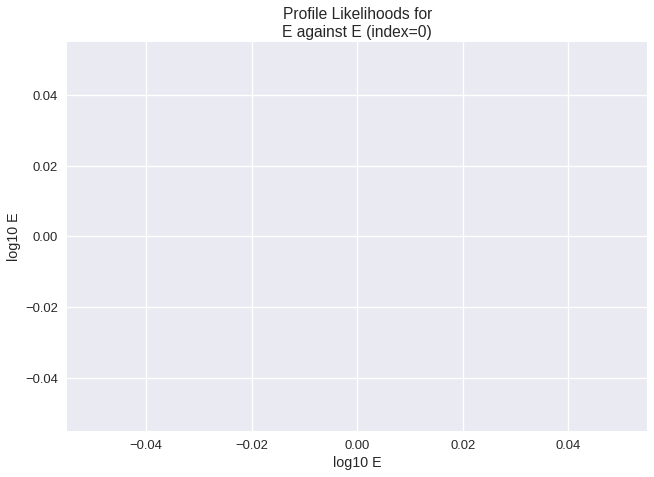

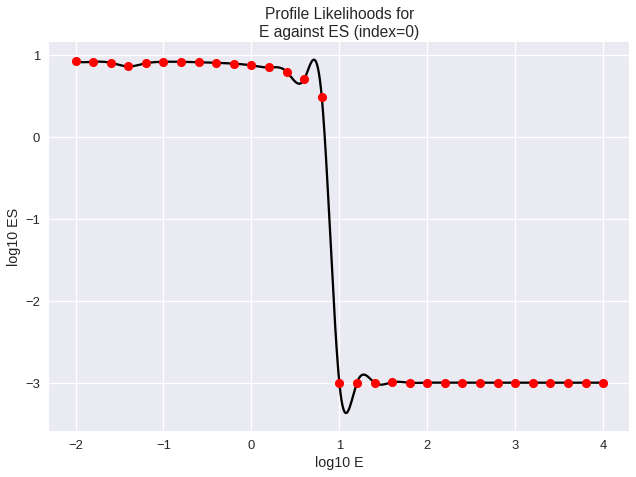

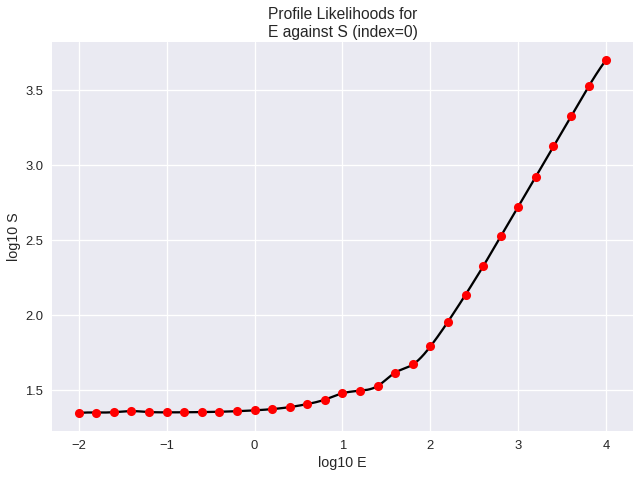

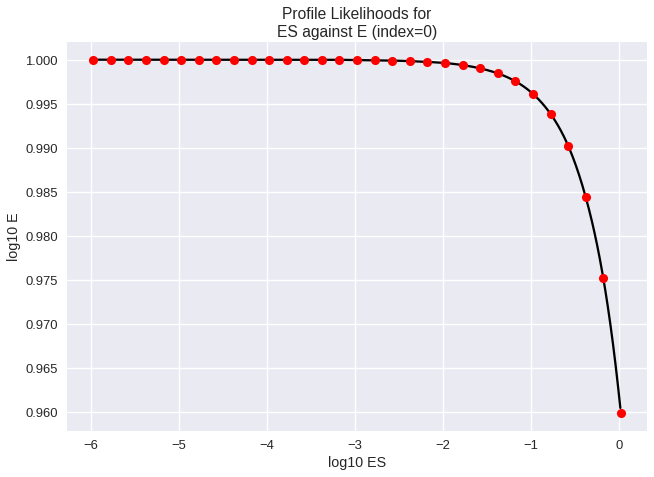

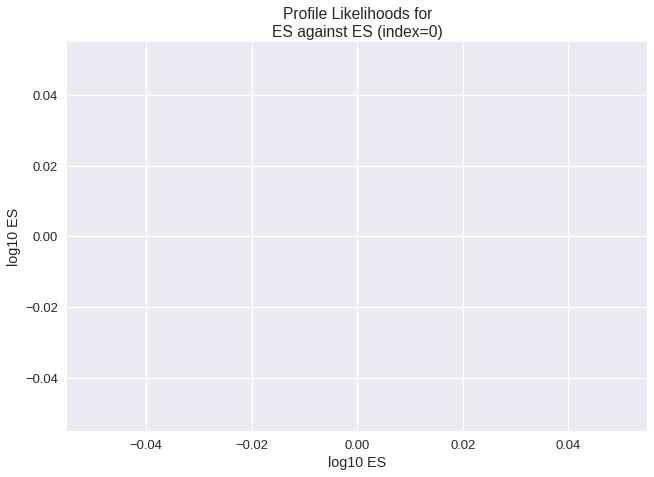

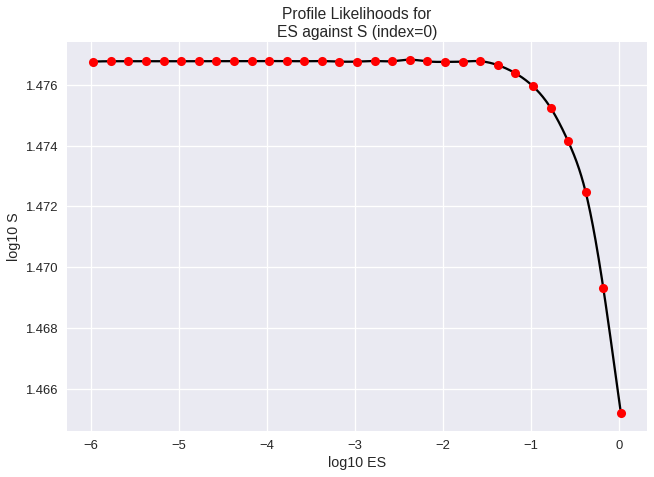

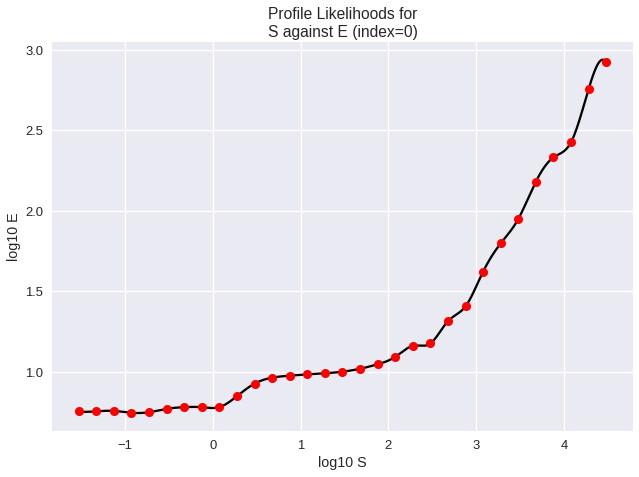

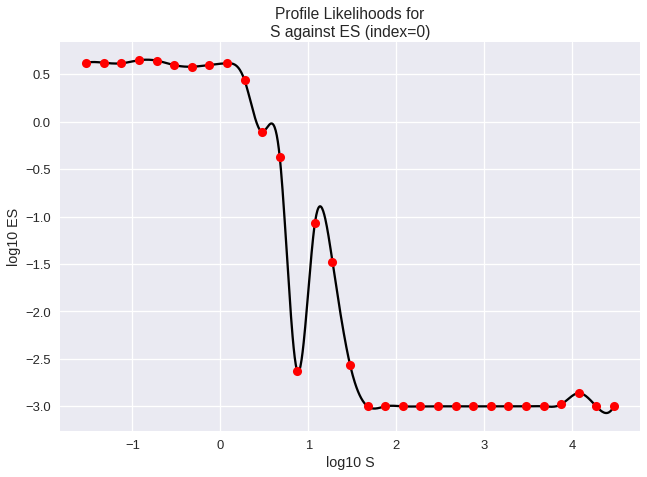

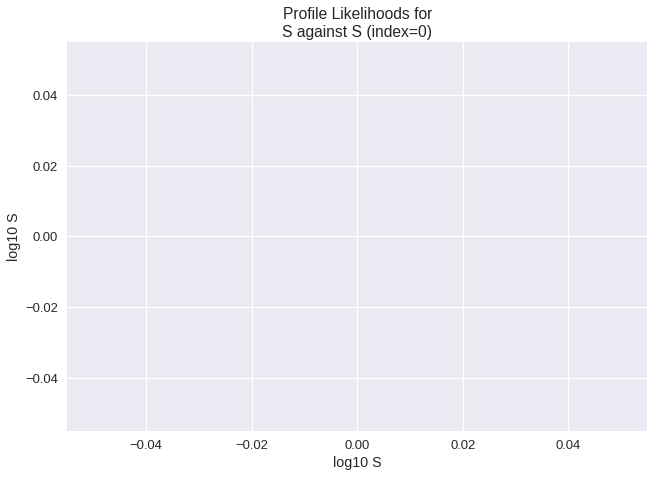

In [23]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', x=['E', 'ES', 'S'], y=['E', 'ES', 'S'], savefig=True)

### Summary for Round 1

#### Optimization performance

    * Not the best performing algorithm because of a lack of step-like shape on the Likelihood ranks plot or tight clustering on the PCA. However the data is still worth analyzing further. 
    
#### Trajectories
    
    * All data fits the profiles reasonably well 
    
#### Distributions
    
    * Boxplots give good overview. E, S and Kcat parameters are well defined by the parameter estimation and have tight parameter distributions. Histograms verify these and suggest the estimates are normally distributed around the best parameter values. I would suggest that these parameters are stiff.  
    * Other parameters are less well defined. It might be that the model is simply less sensitive to these parameters (i.e. these are sloppy parameters)
    
#### Correlations
Two relationships are linearly correlated with a high degree of statistical significance

    * (S bind E).kf and (S unbind E).kb have an $r^2$ of 0.9999 (p-value = 8.77e-102)
    * E and ES have a $r^2$ of -0.89 (p-value = 4.83e-15)
    
#### Profile Likelihoods

Despite some parameters being sloppy and having distribution spaning multiple orders of magnitude (boxplots), all but P and ES parameter are identifiable. Incidently these parameters are both 0 in the original model which is very difficult to estimate and ideally shouldn't be estimated.  


### Modifications for Fit2
The information ascertained in the first round of parameter estimations can be used to refine the optimization problem for subsequent rounds. For example, we know that ES being an intermediate species could start as 0 and P being a product could also start as 0. Therefore we could set these to 0 and not estimate them to resolve the two non-identifiabilities. This additionally resolves the E Vs ES correlation since the ES parameter would be fixed to 0. To resolve the other correlation, one of the participants could be fixed. However, since both are identifiable they can be left. 

### Best parameters Versus True Parameters
 * kf = 0.01
 * kb = 0.1
 * kcat = 0.05
 * S = 30
 * E = 10
 * ES = 0
 * P = 0
 

In [29]:
viz.Parse(fit1).data.iloc[0]

E                       9.999950
ES                      0.009395
P                       0.001723
S                      29.899600
(ES produce P).kcat     0.049285
(S bind E).kf           0.013162
(S unbind E).kb         0.146519
RSS                     0.021981
Name: 0, dtype: float64